## Install the package dependencies before running this notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lstm_encoder_decoder_no_early

In [3]:
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random

import math
# import torchnlp

import gc
import os, os.path 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import time

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- val: 55029 test:7971
    # pittsburgh -- val: 43544 test: 6361
    # dearborn -- val: 24465 test: 3671
    # washington-dc -- val: 25744 test: 3829
    # palo-alto -- val:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- val: 55029 test:7971\n    # pittsburgh -- val: 43544 test: 6361\n    # dearborn -- val: 24465 test: 3671\n    # washington-dc -- val: 25744 test: 3829\n    # palo-alto -- val:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [4]:
ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test", "val"] 

def get_city_trajectories(city="palo-alto", split="train", SEED=42):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)

        np.random.seed(SEED)
        shuffler = np.random.permutation(n)
        
        inputs = np.asarray(inputs)
        inputs = inputs[shuffler]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        outputs = outputs[shuffler]
        

    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = torch.zeros(n,60, 2).to(device)

    return inputs, outputs


class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 120)
        )
        
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn_pos_inputs = self.input_positions_centered
        self.nn_velo_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn_pos_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn_velo_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn_pos_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn_pos_inputs[idx], 
                self.nn_pos_outputs[idx], 
                self.nn_velo_inputs[idx], 
                self.nn_velo_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx]
            )
        else:
            data = data = (
                self.nn_pos_inputs[idx], 
                self.nn_velo_inputs[idx], 
                self.center[idx]
            )
        return data

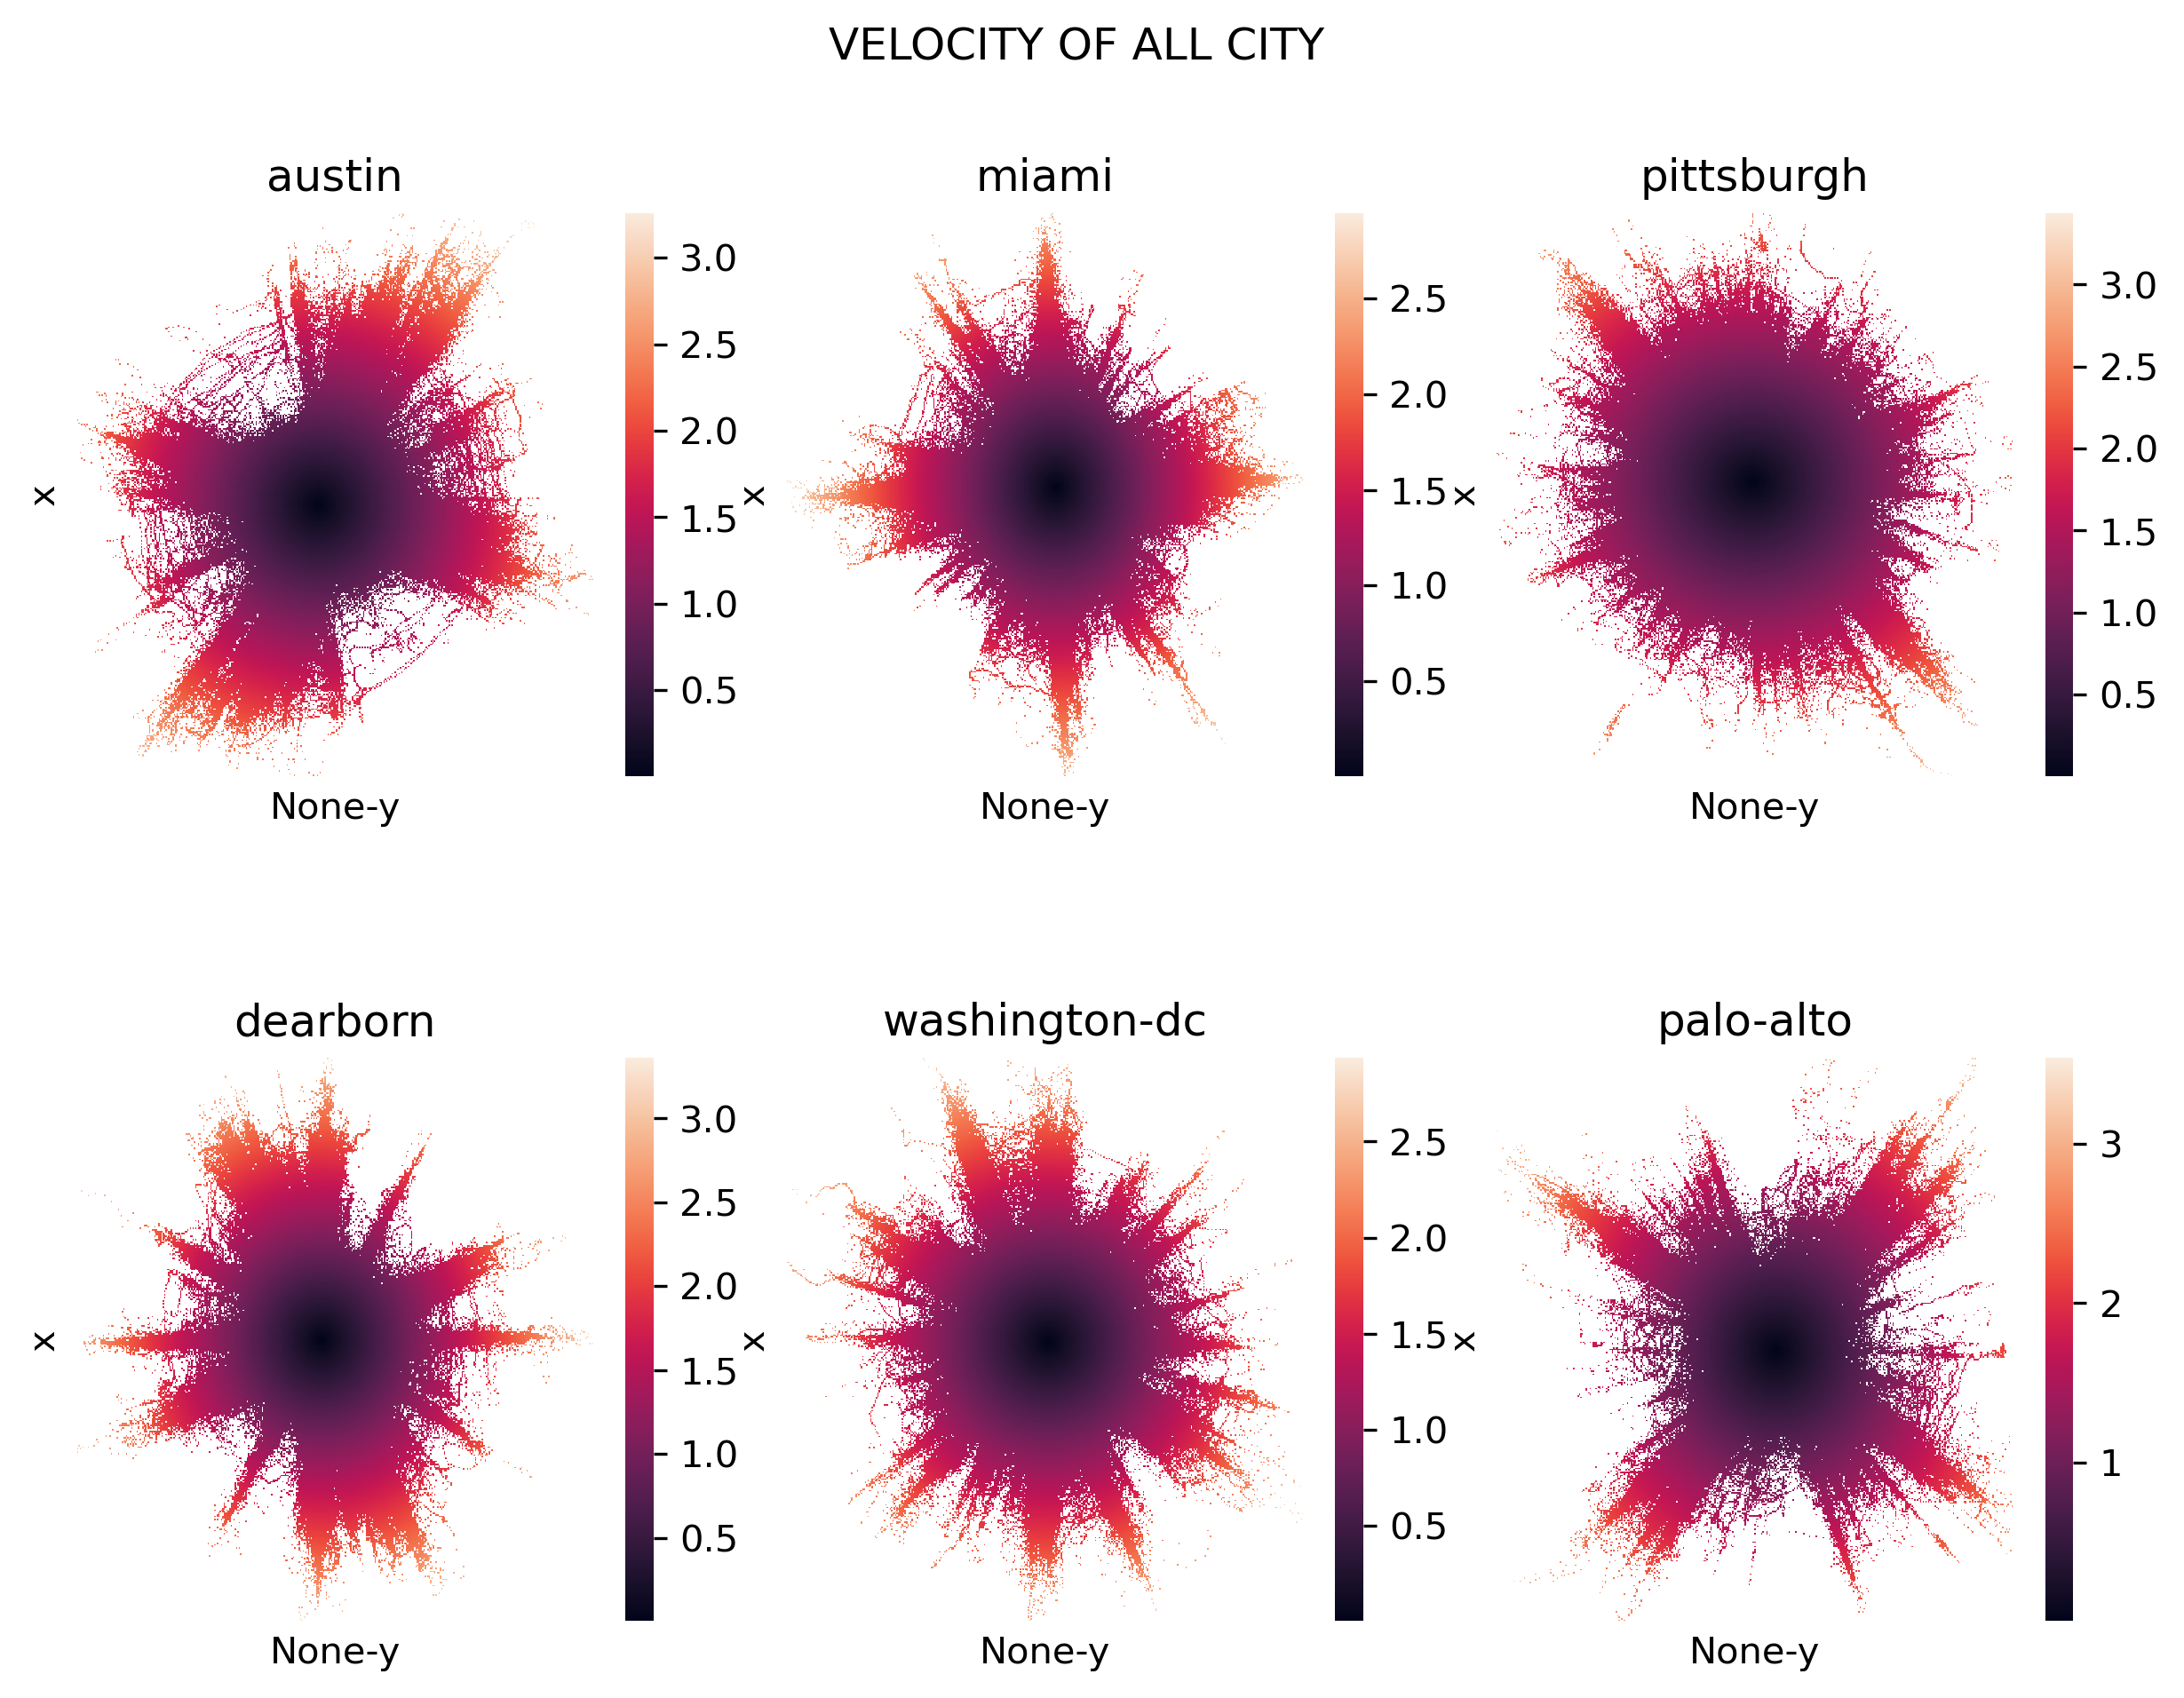

In [22]:
import seaborn as sns


fig, axs = plt.subplots(2,len(cities)//2, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()  



for city, j  in zip(cities, np.arange(len(cities))):

    train_dataset = ArgoverseDataset(city, 'train')
    inp_pos = train_dataset.input_positions
    out_pos = train_dataset.output_positions
    
    
    velo = np.concatenate((inp_pos, out_pos), axis= 1)
    velo = np.diff(velo, axis= 1)

    velo = velo.reshape(velo.shape[0] * velo.shape[1], velo.shape[2])
    velo = pd.DataFrame(velo, columns= ['x','y'])
    velo['v'] = np.sqrt(velo['x']**2 + velo['y']**2)
#     display(velo)
    velo['x'] = pd.cut(velo['x'], bins =400)
    velo['y'] = pd.cut(velo['y'], bins =400)
#     display(velo)
    table = pd.pivot_table(velo, values =['v'], index= ['x'], columns = ['y'], aggfunc = np.mean)
#     display(table)
    
    
    sns.heatmap(table, ax = axs[j])
    axs[j].xaxis.set_ticks([])
    axs[j].yaxis.set_ticks([])
    axs[j].set_title(city)
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')
    fig.suptitle('Velocity') 
 
    

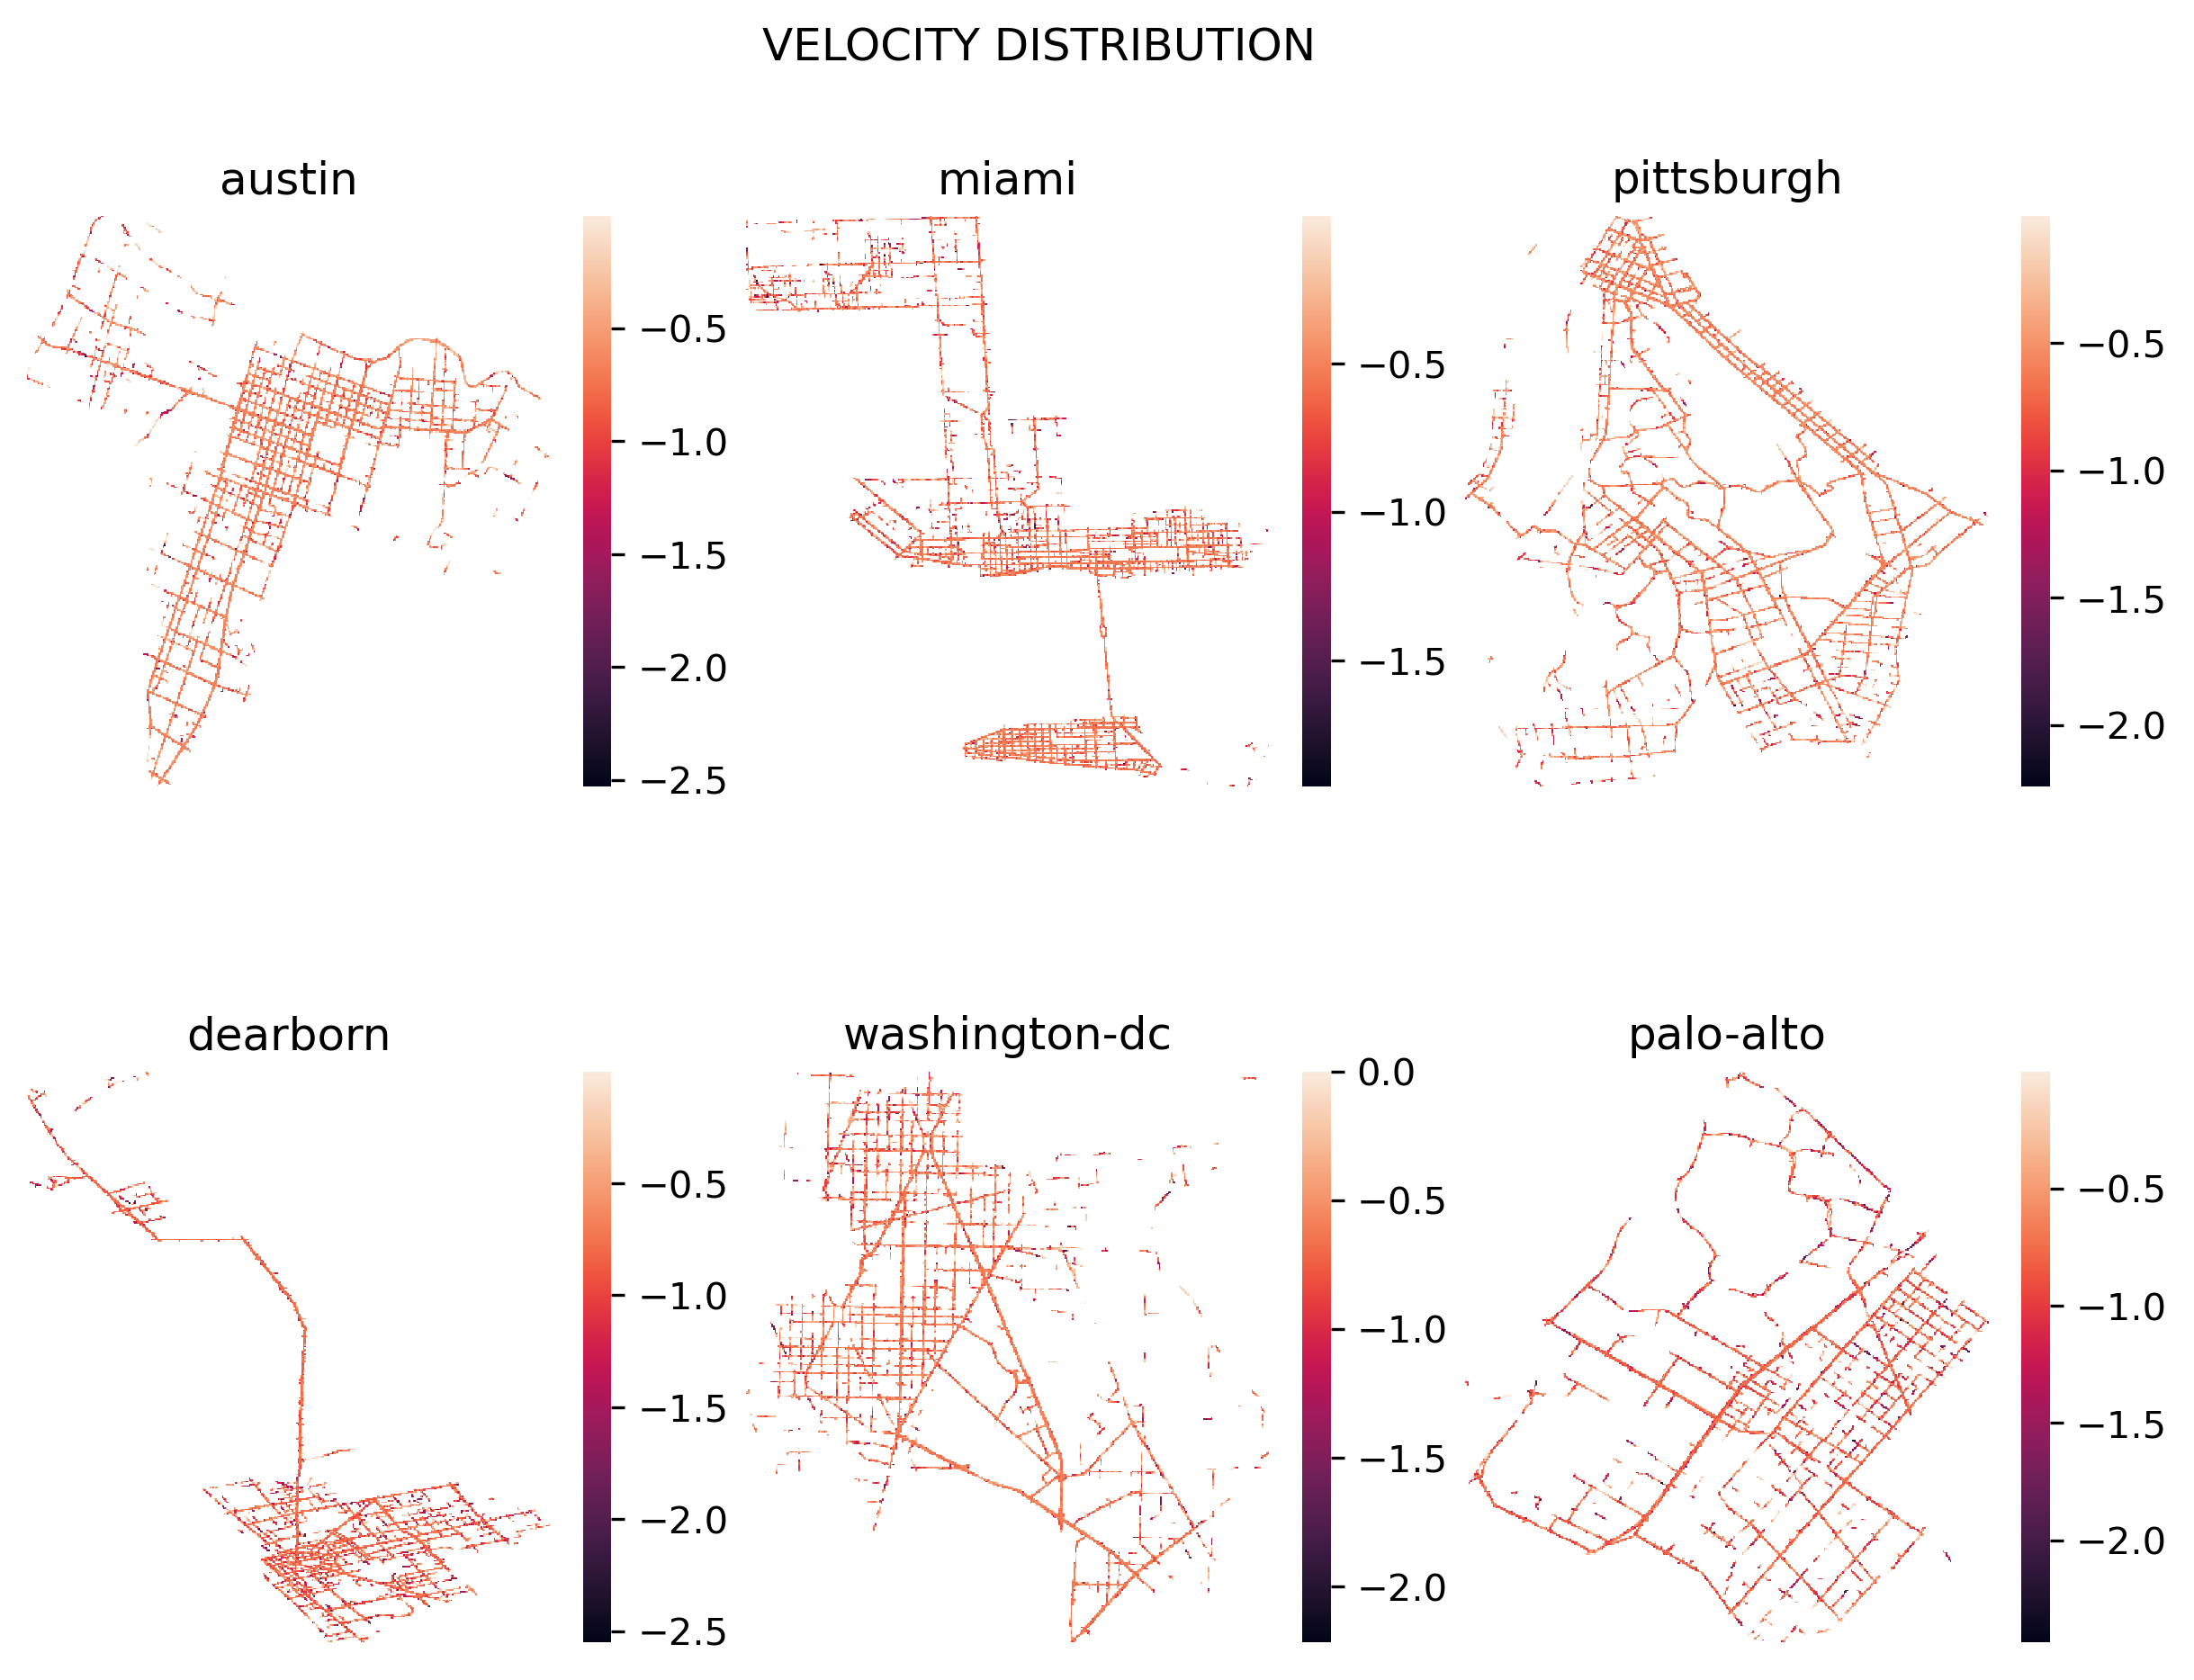

In [35]:
import seaborn as sns


fig, axs = plt.subplots(2,len(cities)//2, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()  



for city, j  in zip(cities, np.arange(len(cities))):

    train_dataset = ArgoverseDataset(city, 'train')
    inp_pos = train_dataset.input_positions
    out_pos = train_dataset.output_positions
    
    
    velo = np.concatenate((inp_pos, out_pos), axis= 1)

    velo = np.diff(velo, axis= 1)

    velo = velo.reshape(velo.shape[0] * velo.shape[1], velo.shape[2])
    velo = pd.DataFrame(velo, columns= ['x','y'])
    velo['v'] = np.sqrt(velo['x']**2 + velo['y']**2)
    velo_pos = np.concatenate((inp_pos, out_pos), axis = 1)
    velo_pos = velo_pos.reshape(velo_pos.shape[0]* velo_pos.shape[1], velo_pos.shape[2])
    velo_pos = pd.DataFrame(velo_pos, columns = ['x','y'])
    velo_pos['v'] = -velo['v']
#     print(velo_pos.shape)
    
    
#     display(velo_pos)
    velo_pos['x'] = pd.cut(velo_pos['x'], bins =400)
    velo_pos['y'] = pd.cut(velo_pos['y'], bins =400)
#     display(velo)
    table = pd.pivot_table(velo_pos, values =['v'], index= ['x'], columns = ['y'], aggfunc = np.mean)
#     display(table)
    
    
    sns.heatmap(table, ax = axs[j], cbar= True)
    axs[j].xaxis.set_ticks([])
    axs[j].yaxis.set_ticks([])
    axs[j].set_title(city) 
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')
    fig.suptitle('Velocity Distribution'.upper()) 
 
    

(2195091, 2)
(2806479, 2)
(2220744, 2)
(1247715, 2)
(1312944, 2)
(611643, 2)


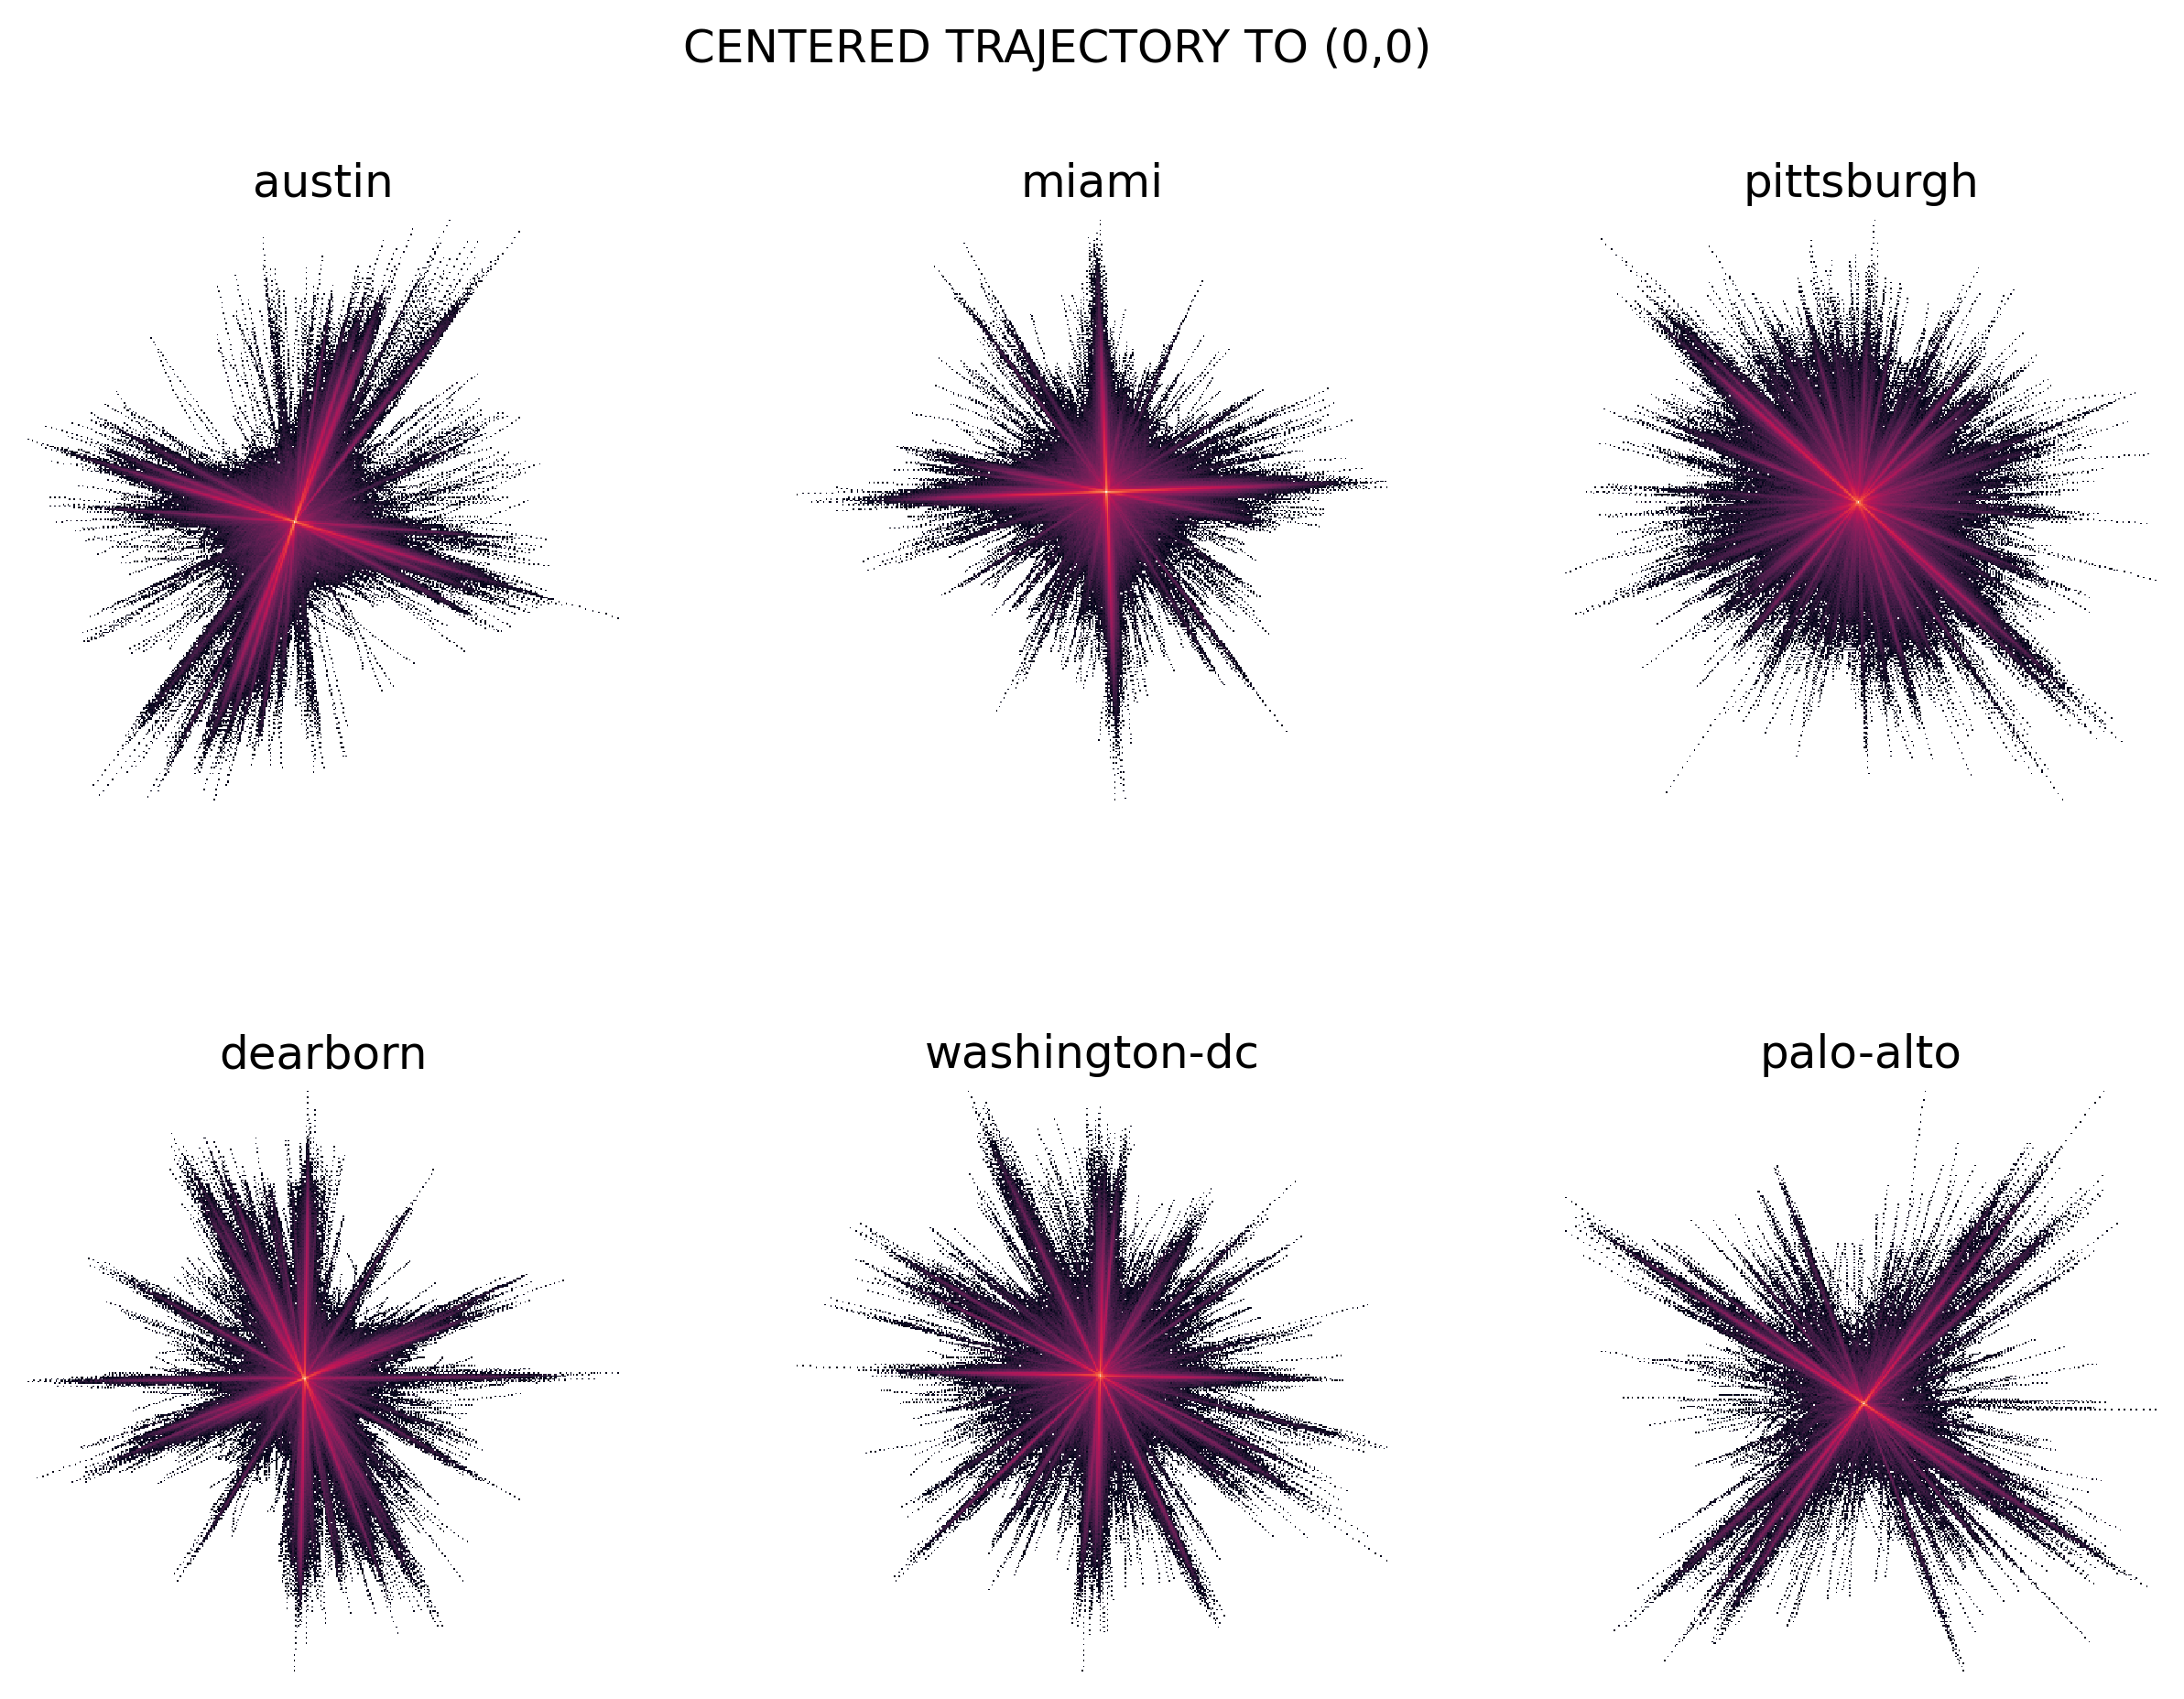

In [20]:
import seaborn as sns


fig, axs = plt.subplots(2,len(cities)//2, figsize=(10,7), facecolor='w', edgecolor='k', dpi =300 )
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs = axs.ravel()  



for city, j  in zip(cities, np.arange(len(cities))):

    train_dataset = ArgoverseDataset(city, 'train')
    inp_pos = train_dataset.nn_pos_inputs
    out_pos = train_dataset.nn_pos_outputs
    
    
    pos = np.concatenate((inp_pos, out_pos), axis= 1)
    pos = pos.reshape(pos.shape[0]*pos.shape[1], pos.shape[2])
#     print(pos.shape)
#     velo = np.diff(velo, axis= 1)

#     velo = velo.reshape(velo.shape[0] * velo.shape[1], velo.shape[2])
    pos = pd.DataFrame(pos, columns= ['x','y'])
#     velo['v'] = np.sqrt(velo['x']**2 + velo['y']**2)
#     display(velo)
    pos['x'] = pd.cut(pos['x'], bins =400)
    pos['y'] = pd.cut(pos['y'], bins =400)
    pos['v']= 1 
    table = pd.pivot_table(pos, values= ['v'],index= ['x'], columns = ['y'], aggfunc = np.sum)
    table = table.replace({0: np.NaN})
    table = np.power(table,0.02)
#     display(table)


    
    sns.heatmap(table, ax = axs[j],cbar= False)
    axs[j].xaxis.set_ticks([])
    axs[j].yaxis.set_ticks([])
    axs[j].set_title(city) 
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')
    fig.suptitle('Centered Trajectory to (0,0)') 
    

In [ ]:
!nvidia-smi

In [ ]:
print(torch.__version__)

In [ ]:
# function that tells how long training takes
def train_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs 

### Random shuffle with seed 42 & add attention

In [ ]:
%%time

# train one model for each city
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city, 'train')
    val_dataset = ArgoverseDataset(city, 'val')


    X_train_nn_pos = train_dataset.nn_pos_inputs.to(device)
    y_train_nn_pos = train_dataset.nn_pos_outputs.to(device)
    X_train_nn_velo = train_dataset.nn_velo_inputs.to(device)
    y_train_nn_velo = train_dataset.nn_velo_outputs.to(device)
    X_train = train_dataset.input_positions.to(device)
    y_train = train_dataset.output_positions.to(device)
    
    X_val_nn_pos = val_dataset.nn_pos_inputs.to(device)
    y_val_nn_pos = val_dataset.nn_pos_outputs.to(device)
    X_val_nn_velo = val_dataset.nn_velo_inputs.to(device)
    y_val_nn_velo = val_dataset.nn_velo_outputs.to(device)
    X_val = val_dataset.input_positions.to(device)
    y_val = val_dataset.output_positions.to(device)

    start_time = time.time()
    nn_pos = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=50,
        output_size=2,
        hidden_size=32,
        num_layers=1,
        dropout=0.
    )

    nn_pos.to(device)

    train_losses_pos, val_losses_pos = lstm_encoder_decoder_no_early.train_model(
        nn_pos,
        city,
        X_train_nn_pos,
        y_train_nn_pos,
        X_train_nn_pos,
        y_train_nn_pos,
        n_epochs=50,
        target_len=1,
        batch_size=64,
        patience = 5,
        threshold = 1e-3,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.001,
        dynamic_tf=False,
        early_stop_criteria = 5,
        device=device,
        model_type='pos'
    )


    plt.title("Loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_pos, color="red", label="train_loss")
    plt.plot(val_losses_pos, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on initial position")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_pos), color="red", label="train_loss")
    plt.plot(np.log(val_losses_pos), color="blue", label="val_loss")
    plt.legend()
    plt.show()


    nn_velo = lstm_encoder_decoder_no_early.lstm_seq2seq(
        input_size=2,
        input_len=49,
        output_size=2,
        hidden_size=128,
        num_layers=1,
        dropout=0.
    )

    nn_velo.to(device)

    train_losses_velo, val_losses_velo = lstm_encoder_decoder_no_early.train_model(
        nn_velo,
        city,
        X_train_nn_velo,
        y_train_nn_velo,
        X_val_nn_velo,
        y_val_nn_velo,
        n_epochs=60,
        target_len=59,
        batch_size=64,
        patience = 10,
        threshold = 1e-4,
        training_prediction='mixed_teacher_forcing',
        teacher_forcing_ratio=0.6,
        learning_rate=0.0001,
        dynamic_tf=False,
        early_stop_criteria = 12,
        device=device,
        model_type='velo'
    )

    plt.title("Loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses_velo, color="red", label="train_loss")
    plt.plot(val_losses_velo, color="blue", label="val_loss")
    plt.legend()
    plt.show()

    plt.title("Log loss for " + city + " on velocity")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(np.log(train_losses_velo), color="red", label="train_loss")
    plt.plot(np.log(val_losses_velo), color="blue", label="val_loss")
    plt.legend()
    plt.show()

    end_time = time.time()
    train_mins, train_secs = train_time(start_time, end_time)
    print(
        f'Total training time is: {train_mins}m {train_secs}s' + ' for ' + city)

### Generate CSV

In [ ]:
%%time

num_layers_pos = 1
num_layers_velo = 1
device = 'cpu'

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')

    model_pos = pickle.load(open('../models/seq2seq_lstm_pos_atten_1000_' + str(num_layers_pos) + '_' + city, 'rb'))
    model_velo = pickle.load(open('../models/seq2seq_lstm_velo_atten_' + str(num_layers_velo) + '_' + city, 'rb'))

    model_pos.to(device)
    model_velo.to(device)

    model_pos.eval()
    model_velo.eval()

    rows = []
    c = 0
    for n in range(test_dataset.__len__()):
        if n % int(test_dataset.__len__() / 1000) == 0 and n > 0: 
            c += 1
            print(str(100 * c / 1000) + '% completed for ' + str(city))
        nn1_nth_input, nn2_nth_input, center_input = test_dataset.__getitem__(n)
        init_pos = torch.Tensor(lstm_encoder_decoder_no_early.predict(model_pos, nn1_nth_input, 1))
        deltas = torch.Tensor(lstm_encoder_decoder_no_early.predict(model_velo, nn2_nth_input, 59))
        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

In [ ]:
# num_layers_pos = 1
# num_layers_velo = 1
# batch_size = 128
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# all_preds = []
# for city in cities:
#     gc.collect()
#     torch.cuda.empty_cache()
#     test_dataset = ArgoverseDataset(city=city, split='test')

#     X_test_nn_pos = test_dataset.nn_pos_inputs.to(device)
#     X_test_nn_velo = test_dataset.nn_velo_inputs.to(device)
#     center_test = test_dataset.center.to(device)

#     otuputs = []

#     model_pos = torchnlp.utils.flatten_parameters(model_pos)
#     model_velo = torchnlp.utils.flatten_parameters(model_velo)



#     n_batches_test = int(X_test_nn_pos.shape[0] / batch_size)
#     last_batch_size = X_test_nn_pos.shape[0] % batch_size


#     # outputs tensor
#     outputs_all = torch.zeros(1, 120).to(device)
    
#     for b in range(n_batches_test):
#         gc.collect()
#         torch.cuda.empty_cache()
#         # select data
#         input_batch_pos = X_test_nn_pos[b: b + batch_size, :, :]
#         input_batch_velo = X_test_nn_velo[b: b + batch_size, :, :]

#         # outputs tensor
#         outputs_pos = torch.zeros(batch_size, 1, input_batch_pos.shape[2]).to(device)
#         outputs_velo = torch.zeros(batch_size, 59, input_batch_velo.shape[2]).to(device)

#         # encoder outputs
#         encoder_output_pos, concat_hidden_pos = model_pos.encoder(input_batch_pos)
#         encoder_output_velo, concat_hidden_velo = model_velo.encoder(input_batch_velo)

#         # decoder with teacher forcing
#         # shape: (batch_size, input_size)
#         decoder_input_pos = input_batch_pos[:, -1, :]
#         decoder_hidden_pos = concat_hidden_pos

#         decoder_input_velo = input_batch_velo[:, -1, :]
#         decoder_hidden_velo = concat_hidden_velo

#         for t in range(1):
#             decoder_hidden_pos = (decoder_hidden_pos[0].squeeze(0), decoder_hidden_pos[1].squeeze(0))
#             decoder_output_pos, decoder_hidden_pos = model_pos.attn_decoder(decoder_input_pos.squeeze(), decoder_hidden_pos, encoder_output_pos)
            
#             outputs_pos[:, t, :] = decoder_output_pos

#         for t in range(59):
#             decoder_hidden_velo = (decoder_hidden_velo[0].squeeze(0), decoder_hidden_velo[1].squeeze(0))
#             decoder_output_velo, decoder_hidden_velo = model_velo.attn_decoder(decoder_input_velo.squeeze(), decoder_hidden_velo, encoder_output_velo)
#             outputs_velo[:, t, :] = decoder_output_velo
#             decoder_input_velo = decoder_output_velo
            


#         outputs_batch = torch.cumsum(torch.cat((outputs_pos, outputs_velo), dim=1), dim=1).view(batch_size, 120) + center_test[b: b + batch_size, :]
#         outputs_all = torch.cat((outputs_all, outputs_batch), 0)

#         gc.collect()
#         torch.cuda.empty_cache()

#     # last batch
#     print(city + ' is finished.')
#     outputs_pos = torch.zeros(last_batch_size, 1, input_batch_pos.shape[2]).to(device)
#     outputs_velo = torch.zeros(last_batch_size, 1, input_batch_velo.shape[2]).to(device)
#     outputs_batch = torch.cumsum(torch.cat((outputs_pos, outputs_velo)), dim=0).view(last_batch_size, 120) + center_test[b: b + batch_size, :]
#     outputs_all = torch.cat((outputs_all, outputs_batch), 0)

#     pred = outputs_all[1:,].cpu().numpy()
        
#     # set up id accordingly 
#     ids = np.array([str(i) + '_' + city for i in range(len(pred))])
#     cols = np.array(['v' + str(i) for i in range(120)])
#     predictions = pd.DataFrame(pred, columns=cols)
#     predictions.insert(0, 'ID', ids)
#     all_preds.append(predictions)
#     gc.collect()
#     torch.cuda.empty_cache()
# all_predictions = pd.concat(all_preds, ignore_index=True)


In [ ]:
all_predictions.to_csv('two_lstm_enc_dec_out_6.csv', index=False)